# Integrate Object Represantations to Gaze Dataframe

In [3]:
# import common libraries
import numpy as np
import pandas as pd
import cv2
import os
import random
import sys
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import multiprocessing as mp
from operator import itemgetter 
import tables
import scipy.io as sio
from scipy.ndimage.measurements import center_of_mass
from scipy.spatial.distance import euclidean
from scipy.io.arff import loadarff 
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import Rectangle #changed

In [4]:
#import detectron2 framework --> INSTALL: https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md
import detectron2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

from utils.graphic_utils import *
from utils.detectron_utils import *
from utils.dataframe_utils import *
from utils.matlab_utils import *


## Set local paths
### Requierments:
- Results of Panoptic Segmentation: _data.npy, _final.npy --> If not available check README
- GazeCom_ground_truth & GazeCom video files: http:// www.inb.uni-luebeck.de/tools-demos/gaze
- Proto Objects (computed in Matlab, also check README)


In [5]:

################## SET PATHS ##################
PANOPTIC_DATA_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/'
PANOPTIC_VIDEO_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/'

RESULTS_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/detect_video/'

GAZE_COM_GAZE_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/'
GAZE_COM_VIDEO_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK/'

PROTO_OBJECT_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/'
DETECTRON_METADATA = 'detectron2_metadata.npy'
################## SET PATHS ##################


metadata = np.load(DETECTRON_METADATA, allow_pickle=True)
stuff_classes = metadata[1][1]
thing_classes = metadata[2][1]

gaze_folder_list = [video for video in glob.glob(GAZE_COM_GAZE_DIR + '/*')]
gaze_folder_list.sort()

video_path_list = [video for video in glob.glob(GAZE_COM_VIDEO_DIR + '/*')]
video_path_list.sort()

data_path_list = [video for video in glob.glob(PANOPTIC_DATA_DIR + '*_data.npy')]
data_path_list.sort()

info_path_list = [video for video in glob.glob(PANOPTIC_DATA_DIR + '*_deepsort.npy')]
info_path_list.sort()


## Make Gaze Event Dataframe

In [9]:
path = GAZE_COM_GAZE_DIR
files = []
for r, d, f in os.walk(path):
    for file in f:
        if '.arff' in file:
            files.append(os.path.join(r, file))

print('Number of files: ',len(files),'\nExample string: ', files[0], '\nVideo: ', files[0].split('/')[-2], ', Subject: ', files[0].split('/')[-1][:3])

Number of files:  844 
Example string:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/bridge_1/SSK_bridge_1.arff 
Video:  bridge_1 , Subject:  SSK


In [ ]:
df_res = pd.DataFrame()
for i, f in enumerate(files):
    gaze_arff = loadarff(f)[0]
    vid = f.split('/')[-2]
    subj = f.split('/')[-1][:3]
    df = pd.DataFrame.from_records(gaze_arff)
    df['time']-=df['time'][0]
    df = df.groupby(df['handlabeller_final'].ne(df['handlabeller_final'].shift()).cumsum())
    df = df.apply(lambda entry: pd.DataFrame({
        'start_time':[entry['time'].iloc[0]/1000.],
        'end_time':[(entry['time'].max())/1000.], 
        'duration':[(entry['time'].max()-entry['time'].min())/1000.], 
        'dx':[entry['x'].iloc[-1] - entry['x'].iloc[0]], 
        'dy':[entry['y'].iloc[-1] - entry['y'].iloc[0]], 
        'start_x':[entry['x'].iloc[0]], 
        'start_y':[entry['y'].iloc[0]], 
        'end_x':[entry['x'].iloc[-1]], 
        'end_y':[entry['y'].iloc[-1]], 
        'event':[entry['handlabeller_final'].iloc[0]],
        })).reset_index(drop=True)
    df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2) * px_to_deg_conv
    df['angle'] = np.arctan2(df['dy'],df['dx'])  /np.pi *180
    df['subject'] = subj
    df['video'] = vid

    df_res = pd.concat([df_res,df])

df_res = df_res.sort_values(['video', 'subject'], ascending=[True, True])
df_res = df_res.reset_index(drop=True)
df_res.to_pickle('gazecom_gt_event_df')

In [11]:
path = 'gazecom_gt_event_df'
df_gt_event = pd.read_pickle(path)
df_gt_event

,start_time,end_time,duration,dx,dy,start_x,start_y,end_x,end_y,event,distance,angle,subject,video
0,0.0,273.0,273.0,48.2,100.5,590.9,5.2,639.1,105.7,4.0,4.154712,64.377531,AAF,beach
1,277.0,313.0,36.0,71.8,250.1,639.3,110.1,711.1,360.2,2.0,9.699074,73.982013,AAF,beach
2,317.0,524.0,207.0,19.2,32.4,712.5,362.6,731.7,395.0,1.0,1.403843,59.349332,AAF,beach
3,528.0,550.0,22.0,-8.2,217.1,732.2,396.9,724.0,614.0,2.0,8.098200,92.163068,AAF,beach
4,551.0,1023.0,472.0,59.2,-147.1,724.5,614.1,783.7,467.0,1.0,5.910552,-68.077813,AAF,beach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85965,19260.0,19292.0,32.0,100.7,-5.2,419.3,361.6,520.0,356.4,2.0,3.758606,-2.956044,YFK,street
85966,19296.0,19485.0,189.0,-21.5,0.8,518.5,356.8,497.0,357.6,1.0,0.801970,177.869047,YFK,street
85967,19489.0,19513.0,24.0,-47.6,-4.3,494.3,358.0,446.7,353.7,2.0,1.781521,-174.838132,YFK,street
85968,19521.0,19868.0,347.0,-54.0,-34.6,449.6,353.3,395.6,318.7,3.0,2.390600,-147.350658,YFK,street


## Make Correlation Dataframe

In [7]:
df_res = pd.DataFrame()
for i, f in enumerate(tqdm(files)):
    df = load_df(f)
    df_res = pd.concat([df_res,df])

df_res = df_res.sort_values(['video', 'subject'], ascending=[True, True])
df_res = df_res.reset_index(drop=True)

df_res.to_pickle('gazecom_gaze_df')
df_res

,time,x,y,handlabeller_final,video,subject,class_label,isThing,track_id
0,0.0,591.0,5.0,NOISE,beach,AAF,,,NaN
1,4.0,591.0,5.0,NOISE,beach,AAF,,,NaN
2,8.0,591.0,5.0,NOISE,beach,AAF,,,NaN
3,12.0,590.0,5.0,NOISE,beach,AAF,,,NaN
4,16.0,590.0,5.0,NOISE,beach,AAF,,,NaN
...,...,...,...,...,...,...,...,...,...
5000,20112.0,376.0,360.0,NOISE,street,YFK,,,NaN
5001,20116.0,375.0,359.0,NOISE,street,YFK,,,NaN
5002,20120.0,374.0,359.0,NOISE,street,YFK,,,NaN
5003,20124.0,372.0,358.0,NOISE,street,YFK,,,NaN


## Integrate Panoptic Segmentation Results to Gaze Data 

In [23]:
radius = 13.35  # 1° of visual angle is equvialent to radius of 13.35 pixel , 2° = 26.7 pixel 
fps=29.97

path = 'data\gazecom_correlation_df'
df_correlation = pd.read_pickle(path)
#df_correlation['class_label'] = ""
#df_correlation['isThing'] = ""
#df_correlation['track_id'] = np.nan


for v,path in tqdm(enumerate(video_path_list[17]), total = len(video_path_list)):

    video_name = os.path.splitext(os.path.basename(path))[0]
    gaze_dir = gaze_folder_list[v] 
    gaze_path_list = [video for video in glob.glob(gaze_dir + '/*')]
    gaze_path_list.sort()
    print('video name: ', video_name, '\nGaze Data Path: ', gaze_dir, '\nPanoptic Seg. Data: ', data_path_list[v], '\nPanoptic Seg. Info: ', info_path_list[v])
    ##### Load panoptic segmentation results #####
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
    segments_info = np.load(info_path_list[v],allow_pickle=True) 

    ##### Iterate over all subject #####
    for gaze_path in tqdm(gaze_path_list, desc=video_name):
    #for gaze_path in [[gaze_path_list][0][0]]: #run single subject
        subject_name = os.path.splitext(os.path.basename(gaze_path))[0][0:3]
        num_frames = min(len(panoptic_seg),len(segments_info))

        ##### Load Gaze from .arff file #####
        df = df_correlation[(df_correlation.video == video_name) & (df_correlation.subject == subject_name)]
        
        ##### Iterate over frames #####
        for f in range(num_frames):
            # The timespan of 1 frame includes around 8 datapoints of the Dataframe, these are temporaly stored in dtemp
            dtemp = df[(df['time'] >= 1e3*f/fps) & (df['time'] < 1e3*(f+1)/fps)] 
            
            for i in dtemp.index:
                ##### Correlation of (x,y) with Panoptic Segmentation #####
                x_coord = int(dtemp['x'][i])
                y_coord = int(dtemp['y'][i])
                track_id = -1

                panoptic_mask = panoptic_seg[f].numpy()
                segment_id = panoptic_mask[y_coord,x_coord]
                isthing = segments_info[f][segment_id-1]['isthing'] #-1 because of indexing
                category_id = segments_info[f][segment_id-1]['category_id']
                if 'track_id' in segments_info[f][segment_id-1]:
                    track_id = segments_info[f][segment_id-1]['track_id']

                if isthing: #if point of interest is thing, label with thing_classes_label
                    label = thing_classes[category_id]

                else: #else check if stuff area of in foveated region contains any other stuff or objects
                    y,x = np.ogrid[-y_coord:720-y_coord, -x_coord:1280-x_coord]
                    r=radius
                    mask = x*x + y*y <= r*r
                    area_of_interest = panoptic_seg[f].numpy()[mask] #circular mask to simulate foveate vision
                    aoi_segment_ids = np.unique(area_of_interest)
                    if len(aoi_segment_ids)>1: #if there are any other stuff or objects, check if the next most dominant one is stuff or thing
                        if segments_info[f][aoi_segment_ids[1]-1]['isthing']: # if the next most dominant one is thing, obtain with thing_class_label
                            category_id = segments_info[f][aoi_segment_ids[1]-1]['category_id']
                            label = thing_classes[category_id]
                            isthing = True
                            
                        else: # obtain with stuff_class_label
                            label = stuff_classes[category_id]
                    else:
                        label = stuff_classes[category_id]

                df.at[i,'class_label'] = label
                df.at[i, 'isThing'] = isthing
                df.at[i, 'track_id'] = track_id

        df_correlation[(df_correlation.video == video_name) & (df_correlation.subject == subject_name)] = df

    df_correlation.to_pickle('gazecom_correlation_df')

video name:  street 
Gaze Data Path:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK_GAZE/GazeCom_ground_truth/street 
Panoptic Seg. Data:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/street_data.npy 
Panoptic Seg. Info:  /Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/street_info_deepsort.npy


## Integrate Proto Objects Results to Gaze Data 
### To draw proto objects in GazeCom videos see GazeComVisualisation.ipynb

In [31]:
radius = 13.35  # 1° of visual angle is equvialent to radius of 13.35 pixel , 2° = 26.7 pixel 
fps=29.97
path = 'gazecom_correlation_df'
df_correlation = pd.read_pickle(path)
df_correlation['motion_proto_id'] = np.nan
df_correlation['walther_proto_id'] = np.nan

for v,path in tqdm(enumerate(video_path_list), total = len(video_path_list)):
#for path in [video_path_list[0]]: #run single video
    video_name = os.path.splitext(os.path.basename(path))[0]
    gaze_dir = gaze_folder_list[v] 
    gaze_path_list = [video for video in glob.glob(gaze_dir + '/*')]
    gaze_path_list.sort()
    print('video name: ', video_name)
    ##### Load Proto Object from .mat file #####
    waltherProto, motionProto = load_proto_objects(PROTO_OBJECT_DIR, video_name)

    ##### Iterate over all subject #####
    for s,gaze_path in tqdm(enumerate(gaze_path_list), total = len(gaze_path_list), desc=video_name):
    #for gaze_path in [[gaze_path_list][0][0]]: #run single subject

        subject_name = os.path.splitext(os.path.basename(gaze_path))[0][0:3]
        num_frames = min(waltherProto.shape[0], motionProto.shape[0])

        ##### Select part of Dataframe for specific video & subject #####
        df = df_correlation[(df_correlation.video == video_name) & (df_correlation.subject == subject_name)]
        
        ##### Iterate over frames #####
        for f in range(num_frames):
            # The timespan of 1 frame includes around 8 datapoints of the Dataframe, these are temporaly stored in dtemp
            dtemp = df[(df['time'] >= 1e3*f/fps) & (df['time'] < 1e3*(f+1)/fps)] 
            
            for i in dtemp.index:
                x_coord = int(dtemp['x'][i])
                y_coord = int(dtemp['y'][i])
                track_id = -1

                y,x = np.ogrid[-y_coord:720-y_coord, -x_coord:1280-x_coord]
                r=radius
                mask = x*x + y*y <= r*r

                # MOTION PROTO OBJECT
                proto_score = 0
                motion_proto_id = 0
                for n in range(0,5):
                    resized = cv2.resize(motionProto[f,:,:,n], (1280,720), interpolation = cv2.INTER_AREA)
                    blur = cv2.blur(resized,(20,20))
                    if blur[y_coord][x_coord] != 0:
                        motion_proto_id = n+1
                        break
                    else:
                        area_of_interest = blur[mask] #same mask as for panoptic
                        aoi_segment_ids = np.unique(area_of_interest)
                        if len(aoi_segment_ids)>1:
                            motion_proto_id = n+1
                            break

                # WALTHER PROTO OBJECT
        
                walther_proto_id = 0
                for n in range(0,5):
                    resized = cv2.resize(waltherProto[f,:,:,n], (1280,720), interpolation = cv2.INTER_AREA)
                    blur = cv2.blur(resized,(20,20))
                    if blur[y_coord][x_coord] != 0:
                        walther_proto_id = n+1
                        break
                    else:
                        area_of_interest = blur[mask] #same mask as for panoptic
                        aoi_segment_ids = np.unique(area_of_interest)
                        if len(aoi_segment_ids)>1:
                            walther_proto_id = n+1
                            break

                df.at[i,'motion_proto_id'] = motion_proto_id
                df.at[i,'walther_proto_id'] = walther_proto_id
               

        df_correlation[(df_correlation.video == video_name) & (df_correlation.subject == subject_name)] = df

    df_correlation.to_pickle('gazecom_correlation_df_proto')


video name:  beach



video name:  breite_strasse



video name:  bridge_1



video name:  bridge_2



video name:  bumblebee



video name:  doves



video name:  ducks_boat



video name:  ducks_children



video name:  golf



video name:  holsten_gate



video name:  koenigstrasse



video name:  puppies



video name:  roundabout



video name:  sea



video name:  st_petri_gate



video name:  st_petri_market



video name:  st_petri_mcdonalds



video name:  street


## Integrate Most Salient Objects Results to Gaze Data 
### To draw most salient objects in GazeCOm videos see GazeComVisualisation.ipynb

### Update segments_info.npy with lowlevel_salient_object 

In [48]:
videos_run =[s for s in range(2,18)]
for v in tqdm(videos_run, desc="videos"):#len(video_path_list)
    videoloc = data_path_list[v] #video_path_list[v]
    video_name = os.path.splitext(os.path.basename(videoloc))[0][:-5]
    #print('Video: %s' % videoloc)
    #vid = imageio.get_reader(videoloc,  'ffmpeg')

    most_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/'
    save_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/' + video_name + '_lowlevel-salient-objects.npy'

    saliency_map_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/mySaliency/' + video_name + '.mat'
    saliency_map_file = sio.loadmat(saliency_map_path)
    saliency_maps = np.asarray(saliency_map_file['video_saliency'])#np.asarray(saliency_map_file['video_saliency'])
    saliency_maps = np.moveaxis(saliency_maps, 2, 0)
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
    segments_info = np.load(info_path_list[v],allow_pickle=True) ## change back later!! to v
    # Load bottom-up saliency and panoptic segmentation, update segments_info, for 'most salient'

    num_sal_objects = 5
    max_sal_things = np.zeros((num_frames,num_sal_objects))

    salient_object_ids = []

    for f in range(min(len(panoptic_seg),len(saliency_maps))):
        resized = cv2.resize(saliency_maps[f,:,:], (1280,720), interpolation = cv2.INTER_AREA)
        saliency_map = cv2.blur(resized,(20,20))
        panoptic_mask = panoptic_seg[f].numpy()
    

        for segment in segments_info[f]:
            if not segment['isthing']:
                first_stuff_id = (segment['id']) # instance_id?
                break
            
        labeled_thing_map = np.where(panoptic_mask<first_stuff_id,panoptic_mask,0) #All things to segment_id, stuff is 0
        mean_thing_saliency = []
        mean_thing_saliency.append(0) #for 0 segment, as it is excluded in for loop 
        salient_object_mask = np.zeros((720,1280))
        for things_id in range(1,first_stuff_id-1): # exclude segment 0
            single_thing_saliency = np.where(labeled_thing_map==things_id,1,0)*saliency_map
            mean_thing_saliency.append(np.mean(single_thing_saliency))
        mean_thing_saliency = np.asarray(mean_thing_saliency)
        max_sal_things = mean_thing_saliency.argsort()[-min(num_sal_objects,(first_stuff_id-2)):][::-1] # List with the ids of the most salient panoptic object (-2 instead of -1, cause we added 0 fro segment id 0 in the beginning)
        salient_object_ids.append(max_sal_things) 
        count = 1
        for segment in max_sal_things:
            segments_info[f][segment].update( {'lowlevel_salient_object' : count} )
            count = count + 1

    np.save(save_path,salient_object_ids)     #includes panoptic ids of salient object of each frame
    np.save(info_path_list[v],segments_info) 


bridge_1
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/bridge_1_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bridge_1_data.npy



bridge_2
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/bridge_2_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bridge_2_data.npy



bumblebee
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/bumblebee_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/bumblebee_data.npy



doves
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/doves_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/doves_data.npy



ducks_boat
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/ducks_boat_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/ducks_boat_data.npy



ducks_children
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/ducks_children_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/ducks_children_data.npy



golf
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/golf_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/golf_data.npy



holsten_gate
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/holsten_gate_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/holsten_gate_data.npy



koenigstrasse
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/koenigstrasse_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/koenigstrasse_data.npy



puppies
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/puppies_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/puppies_data.npy



roundabout
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/roundabout_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/roundabout_data.npy



sea
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/sea_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/sea_data.npy



st_petri_gate
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/st_petri_gate_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/st_petri_gate_data.npy



st_petri_market
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/st_petri_market_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/st_petri_market_data.npy



st_petri_mcdonalds
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/st_petri_mcdonalds_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/st_petri_mcdonalds_data.npy



street
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/street_lowlevel-salient-objects.npy
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/street_data.npy


### Update segments_info.npy with motion_salient_object

In [50]:
videos_run =[0,16,17] # Does not make sense for all videos, motion seg. results are only usefull for some videos

for v in tqdm(videos_run, desc="videos"):#len(video_path_list)
    videoloc = data_path_list[v] #video_path_list[v]
    video_name = os.path.splitext(os.path.basename(videoloc))[0][:-5]
   
    most_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/motion-salient-objects/'
    save_path = most_salient_objects_path + video_name + '_motion-salient-objects.npy'

    motion_map_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/motion-seg/' + video_name + '/rigidMotions/'
    motion_map_list = [image for image in glob.glob(motion_map_path + '/*')]
    motion_map_list.sort()
    
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
    segments_info = np.load(info_path_list[v],allow_pickle=True) ## change back later!! to v

    num_sal_objects = 5
    max_sal_things = np.zeros((num_frames,num_sal_objects))
    salient_object_ids = []

    for f in range(min(len(panoptic_seg),len(motion_map_list))):
        motion_map = cv2.imread(motion_map_list[f],0)
        panoptic_mask = panoptic_seg[f].numpy()
    
        for segment in segments_info[f]:
            if not segment['isthing']:
                first_stuff_id = (segment['id']) # instance_id?
                break
            
        labeled_thing_map = np.where(panoptic_mask<first_stuff_id,panoptic_mask,0) #All things to segment_id, stuff is 0
        mean_thing_saliency = []
        mean_thing_saliency.append(0) #for 0 segment, as it is excluded in for loop 
        salient_object_mask = np.zeros((720,1280))
        for things_id in range(1,first_stuff_id-1): # exclude segment 0
            single_thing_saliency = np.where(labeled_thing_map==things_id,1,0)*motion_map # Multiply with Motion_map
            mean_thing_saliency.append(np.mean(single_thing_saliency))
        mean_thing_saliency = np.asarray(mean_thing_saliency)
        max_sal_things = mean_thing_saliency.argsort()[-min(num_sal_objects,(first_stuff_id-2)):][::-1] # List with the ids of the most salient panoptic object (-2 instead of -1, cause we added 0 fro segment id 0 in the beginning)
        salient_object_ids.append(max_sal_things) 
        count = 1
        for segment in max_sal_things:
            segments_info[f][segment].update( {'motion_salient_object' : count} )
            count = count + 1

        
    np.save(save_path,salient_object_ids)     #includes panoptic ids of salient object of each frame
    np.save(info_path_list[v],segments_info) 


### Update Dataframe with motion_salient_object & lowlevel_salient_object

In [41]:
radius = 13.35  # 1° of visual angle is equvialent to radius of 13.35 pixel , 2° = 26.7 pixel 
fps=29.97
path = 'df_foveation'
df_correlation = pd.read_pickle(path)
df_correlation['motion_salient_object'] = np.nan

videos_run = [0,16,17] # Motion Segmentaton results only for video 0,16,17
video_path = itemgetter(*videos_run)(video_path_list)
for v,path in tqdm(enumerate(video_path)):
    print(videos_run[v],path)

#for path in [video_path_list[0]]: #run single video
    video_name = os.path.splitext(os.path.basename(path))[0]
    gaze_dir = gaze_folder_list[v] 
    gaze_path_list = [video for video in glob.glob(gaze_dir + '/*')]
    gaze_path_list.sort()
    """
    lowlevel_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/'
    lowlevel_mask_path = lowlevel_salient_objects_path + video_name + '_lowlevel-salient-objects.npy'
    lowlevel_salient_object_ids = np.load(lowlevel_mask_path,allow_pickle=True) # Includes the segment_id of the 5 lowlevel_salient objects per frame
    """
    motion_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/motion-salient-objects/'
    motion_mask_path = motion_salient_objects_path + video_name + '_motion-salient-objects.npy'
    motion_salient_object_ids = np.load(motion_mask_path,allow_pickle=True) # Includes the segment_id of the 5 motion_salient objects per frame
     
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True)

    ##### Iterate over all subject #####
    for s,gaze_path in tqdm(enumerate(gaze_path_list), total = len(gaze_path_list), desc=video_name):
    #for gaze_path in [[gaze_path_list][0][0]]: #run single subject

        subject_name = os.path.splitext(os.path.basename(gaze_path))[0][0:3]
        ##### Select part of Dataframe for specific video & subject #####
        df = df_correlation[(df_correlation.video == video_name) & (df_correlation.subject == subject_name)]
        #num_frames = min(len(panoptic_seg),len(lowlevel_salient_object_ids))
        num_frames = min(len(panoptic_seg),len(motion_salient_object_ids))
        ##### Iterate over frames #####
        for f in range(num_frames):
            # The timespan of 1 frame includes around 8 datapoints of the Dataframe, these are temporaly stored in dtemp
            dtemp = df[(df['time'] >= 1e3*f/fps) & (df['time'] < 1e3*(f+1)/fps)] 
            panoptic_mask = panoptic_seg[f].numpy()

            #lowlevel_object_list = lowlevel_salient_object_ids[f]
            motion_object_list = motion_salient_object_ids[f]

            for i in dtemp.index:
                x_coord = int(dtemp['x'][i])
                y_coord = int(dtemp['y'][i])
                segment_id = panoptic_mask[y_coord,x_coord]
                """
                if segment_id in lowlevel_object_list:
                    df.at[i,'lowlevel_salient_object'] = np.where(lowlevel_object_list == segment_id)[0][0]
                """
                if segment_id in motion_object_list:
                    df.at[i,'motion_salient_object'] = np.where(motion_object_list == segment_id)[0][0]
               
        df_correlation[(df_correlation.video == video_name) & (df_correlation.subject == subject_name)] = df

    df_correlation.to_pickle(path)

0 /Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK/beach.mpg



16 /Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK/st_petri_mcdonalds.mpg



17 /Users/timschroder/Documents/Uni/Bachelorarbeit/project_data.nosync/LUEBECK/street.mpg


## Area covered by Object Representation

In [6]:
#Area Proto Objects
area_covered_by_thing = []
for v in tqdm(range(0,18)):
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
    segments_info = np.load(info_path_list[v],allow_pickle=True) 
    thing_area = []
    for frame in (range(len(panoptic_seg))):
        area = 0
        for segment in segments_info[frame]:
            if segment['isthing']:
                area = area + segment['area']
        thing_area.append(area)
    area_covered_by_thing.append(np.mean(thing_area)/(1280*720))

In [7]:
#Area Proto Objects
area_covered_by_proto = []
for v,path in tqdm(enumerate(video_path_list), total = len(video_path_list)):
    video_name = os.path.splitext(os.path.basename(path))[0]
    gaze_dir = gaze_folder_list[v] 
    gaze_path_list = [video for video in glob.glob(gaze_dir + '/*')]
    gaze_path_list.sort()
    ##### Load Proto Object from .mat file #####
    waltherProto, motionProto = load_proto_objects(PROTO_OBJECT_DIR, video_name)
    proto_area = []
    for f in range(len(motionProto)):
        resized = np.zeros((720,1280))
        for n in range(0,5):
            resized += cv2.resize(motionProto[f,:,:,n], (1280,720), interpolation = cv2.INTER_AREA)
        proto_area.append(sum(sum(resized)))
    area_covered_by_proto.append(np.mean(proto_area)/(1280*720))


In [8]:
#Area Low Level Most Salient Objects
lowlevel_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/lowlevel-salient-objects/'
area_covered_by_salient_object = []
for v in tqdm(range(0,18)):
    video_name = os.path.splitext(os.path.basename(video_path_list[v]))[0]
    lowlevel_mask_path = lowlevel_salient_objects_path + video_name + '_lowlevel-salient-objects.npy'
    lowlevel_salient_object_ids = np.load(lowlevel_mask_path,allow_pickle=True) # Includes the segment_id of the 5 motion_salient objects per frame
    panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
    segments_info = np.load(info_path_list[v],allow_pickle=True) 
    salient_object_area = []
    for frame in range(min(len(panoptic_seg),len(lowlevel_salient_object_ids))):
        area = 0
        for segment in segments_info[frame]:
            if segment['id'] in lowlevel_salient_object_ids[frame]:
                area = area + segment['area']
        salient_object_area.append(area)
    area_covered_by_salient_object.append(np.mean(salient_object_area)/(1280*720))

In [9]:
#Area Motion Most Salient Objects
lowlevel_salient_objects_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/motion-salient-objects/'
area_covered_by_salient_object_motion = []
for v in tqdm(range(0,18)):
    video_name = os.path.splitext(os.path.basename(video_path_list[v]))[0]
    lowlevel_mask_path = lowlevel_salient_objects_path + video_name + '_motion-salient-objects.npy'
    if os.path.isfile(lowlevel_mask_path):
            
        lowlevel_salient_object_ids = np.load(lowlevel_mask_path,allow_pickle=True) # Includes the segment_id of the 5 motion_salient objects per frame
        panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
        segments_info = np.load(info_path_list[v],allow_pickle=True) 
        salient_object_area = []
        for frame in range(min(len(panoptic_seg),len(lowlevel_salient_object_ids))):
            area = 0
            for segment in segments_info[frame]:
                if segment['id'] in lowlevel_salient_object_ids[frame]:
                    area = area + segment['area']
            salient_object_area.append(area)
        area_covered_by_salient_object_motion.append(np.mean(salient_object_area)/(1280*720))
    else:
        area_covered_by_salient_object_motion.append(0)

In [44]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)

In [416]:
video_names = df_correlation.video.unique()
df_area_things = pd.DataFrame(np.array([(thing_area[v]) for v in range(0,18)]).transpose(), index=thing_classes, columns=video_names)
df_area_stuff.to_pickle('gazecom_area_things_df')
df_area_stuff = pd.DataFrame(np.array([(stuff_area[v]) for v in range(0,18)]).transpose(), index=stuff_classes, columns=video_names)
df_area_stuff.to_pickle('gazecom_area_stuff_df')

In [46]:
covered_by_thing = np.array([sorted(thing_area[v], reverse=True)[:3] for v in range(0,18)]).transpose()
covered_by_stuff = np.array([sorted(stuff_area[v], reverse=True)[:3] for v in range(0,18)]).transpose()
thing_others = [sum(sorted(thing_area[v], reverse=True)[3:]) for v in range(0,18)]
stuff_others = [sum(sorted(stuff_area[v], reverse=True)[3:]) for v in range(0,18)]
thing_label = np.array([np.array(thing_classes)[(-thing_area[v]).argsort()[:3]] for v in range(0,18)]).transpose()
stuff_label = np.array([np.array(stuff_classes)[(-stuff_area[v]).argsort()[:3]] for v in range(0,18)]).transpose()

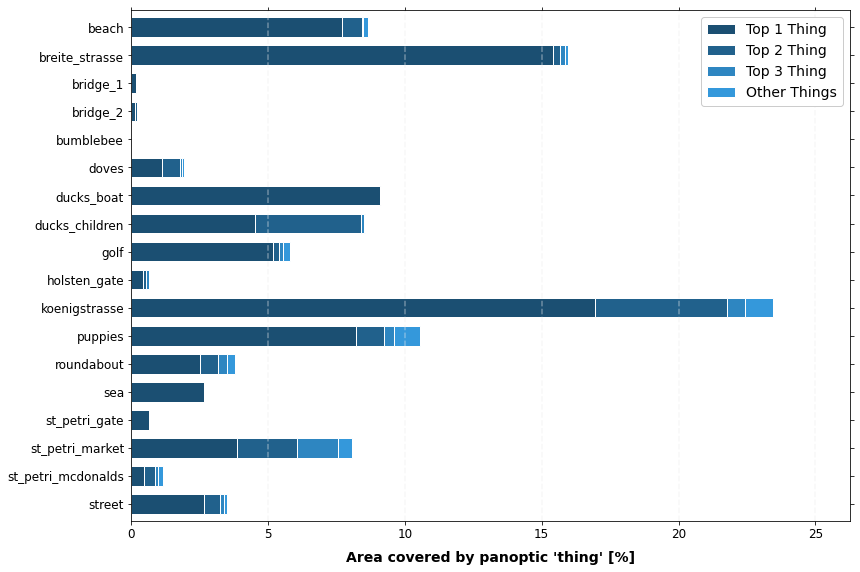

In [427]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)
df_foveation = df_correlation[df_correlation.handlabeller_final.isin(['FIX','SP'])]
video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({'Top 1 Thing': covered_by_thing[0]/vid_area*100,
                        'Top 2 Thing': covered_by_thing[1]/vid_area*100,
                        'Top 3 Thing': covered_by_thing[2]/vid_area*100,
                        'Other Things': np.array(thing_others)/vid_area*100,
                        #'stuff1': covered_by_stuff[0],
                        #'stuff2': covered_by_stuff[1],
                       # 'stuff3': covered_by_stuff[2],
                       # 'stuff_others': stuff_others,
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)

ax = df_bar.plot(kind='barh', label='Correlation of Gaze with Proto Obejcts', stacked=True, color={"#1B4F72" : "Top 1 Thing", "#21618C" : "Top 2 Thing","#2E86C1" : "Top 3 Thing","#3498DB" : "Other Things"},rot=0, fontsize=12, figsize=(12,8), edgecolor = "white", width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)
vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

plt.xlabel("Area covered by panoptic 'thing' [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
x_offset = -0.03
y_offset = 0.02
count = 0
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/area_covered_pan_thing.png', dpi=500)

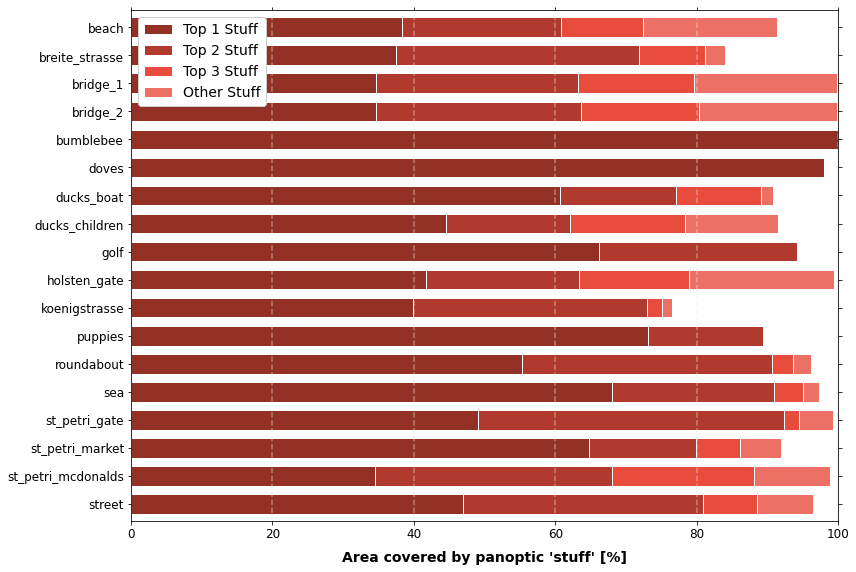

In [428]:
df_foveation = df_correlation[df_correlation.handlabeller_final.isin(['FIX','SP'])]
video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({'Top 1 Stuff': covered_by_stuff[0]/vid_area*100,
                        'Top 2 Stuff': covered_by_stuff[1]/vid_area*100,
                        'Top 3 Stuff': covered_by_stuff[2]/vid_area*100,
                        'Other Stuff': np.array(stuff_others)/vid_area*100,
                        #'stuff1': covered_by_stuff[0],
                        #'stuff2': covered_by_stuff[1],
                       # 'stuff3': covered_by_stuff[2],
                       # 'stuff_others': stuff_others,
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh', label='Correlation of Gaze with Proto Obejcts', stacked=True, color={"#943126" : "Top 1 Thing", "#B03A2E" : "Top 2 Thing","#E74C3C" : "Top 3 Thing","#EC7063" : "Other Things"},rot=0, fontsize=12, figsize=(12,8), edgecolor = "white", width=0.7)
plt.legend(loc=2, facecolor='white', framealpha=1, fontsize=14)
vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlim(0, 100)
plt.xlabel("Area covered by panoptic 'stuff' [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/area_covered_pan_stuff.png', dpi=500)

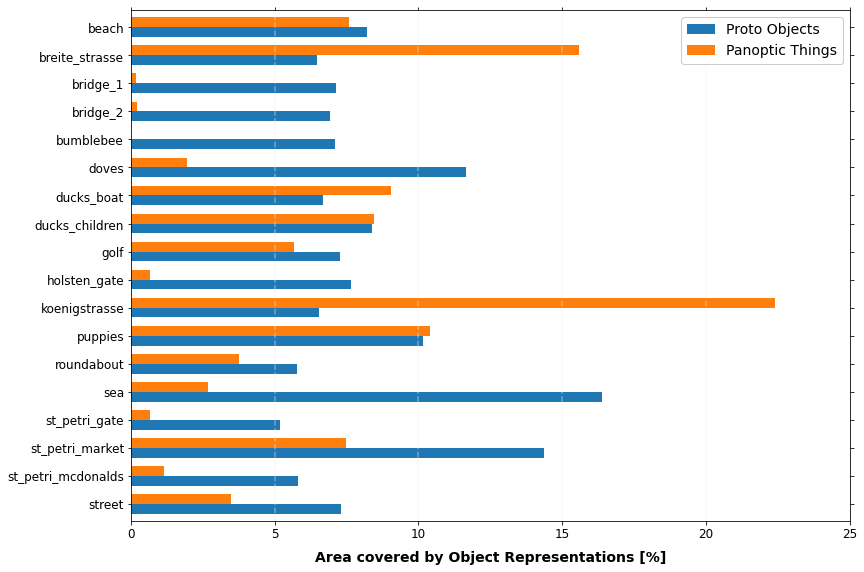

In [64]:
#df_foveation = df_correlation[df_correlation.handlabeller_final.isin(['FIX','SP'])]
video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({'Proto Objects': np.array(area_covered_by_proto)*100,
                        'Panoptic Things': np.array(area_covered_by_thing)*100,
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Area covered by Object Representations [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.xlim(0,25)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/area_covered.png', dpi=500)

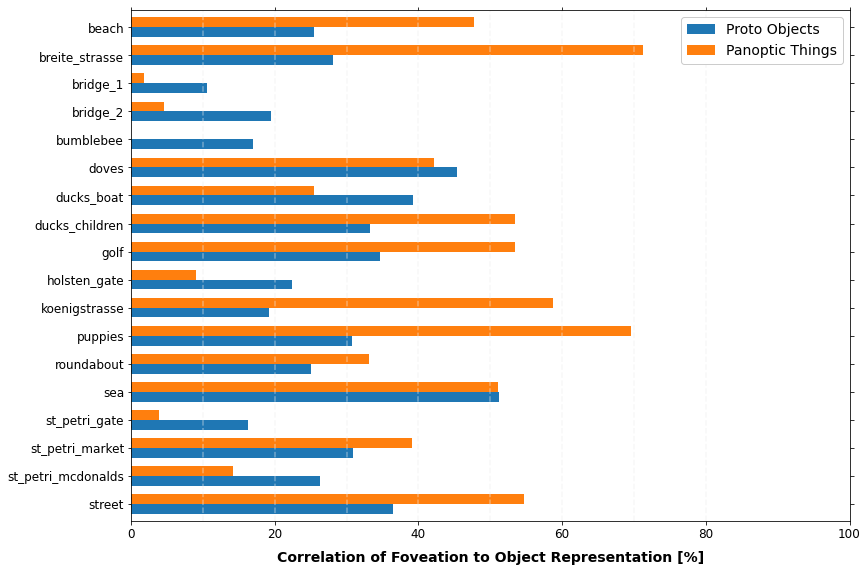

In [53]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)

video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({'Proto Objects': df_foveation.groupby(['video']).mean().proto_object.values*100,
                        'Panoptic Things': df_foveation.groupby(['video']).mean().isThing.values*100
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Correlation of Foveation to Object Representation [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.xlim(0,100)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/corr_both_object_rep.png', dpi=500)

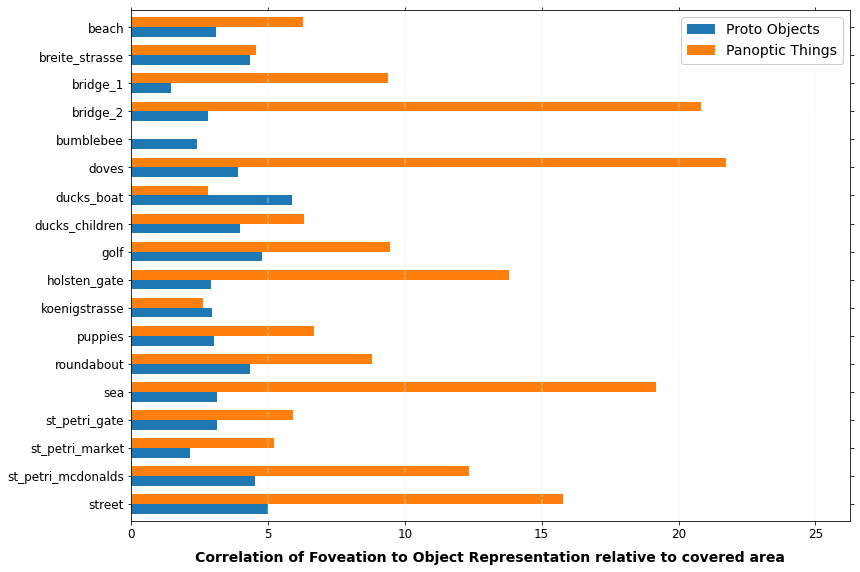

In [72]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)

video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({'Proto Objects': df_foveation.groupby(['video']).mean().proto_object.values/np.array(area_covered_by_proto),
                        'Panoptic Things': df_foveation.groupby(['video']).mean().isThing.values/np.array(area_covered_by_thing)
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Correlation of Foveation to Object Representation relative to covered area",labelpad=10, weight='bold', size=14)
plt.tight_layout()
#plt.xlim(0,100)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/relative_corr_both_object_rep.png', dpi=500)


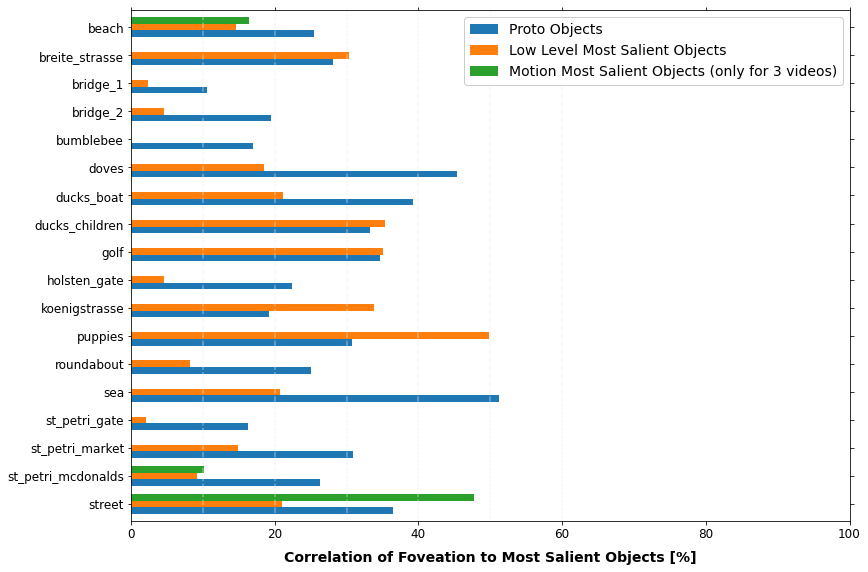

In [55]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)
df_foveation['lowlevel_salient_object_bool'] = np.where(df_foveation['lowlevel_salient_object'].isna(),0,1)
df_foveation['motion_salient_object_bool'] = np.where(df_foveation['motion_salient_object'].isna(),0,1)
video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({
                        'Proto Objects': df_foveation.groupby(['video']).mean().proto_object.values*100,
                        'Low Level Most Salient Objects': df_foveation.groupby(['video']).mean().lowlevel_salient_object_bool.values*100,
                        'Motion Most Salient Objects (only for 3 videos)': df_foveation.groupby(['video']).mean().motion_salient_object_bool.values*100
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Correlation of Foveation to Most Salient Objects [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.xlim(0,100)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/corr_most_salient.png', dpi=500)


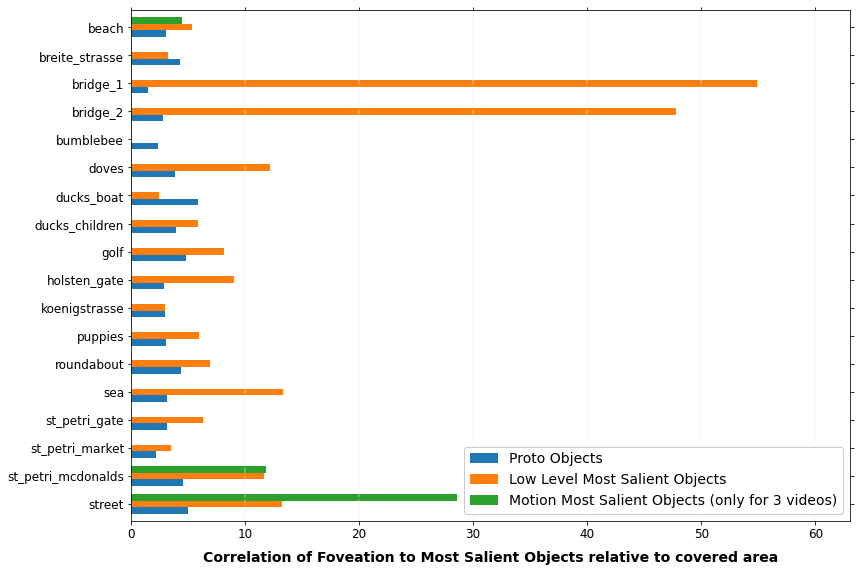

In [61]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)
df_foveation['lowlevel_salient_object_bool'] = np.where(df_foveation['lowlevel_salient_object'].isna(),0,1)
df_foveation['motion_salient_object_bool'] = np.where(df_foveation['motion_salient_object'].isna(),0,1)
video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({
                        'Proto Objects': df_foveation.groupby(['video']).mean().proto_object.values/area_covered_by_proto,
                        'Low Level Most Salient Objects': df_foveation.groupby(['video']).mean().lowlevel_salient_object_bool.values/area_covered_by_salient_object,
                        'Motion Most Salient Objects (only for 3 videos)': df_foveation.groupby(['video']).mean().motion_salient_object_bool.values/area_covered_by_salient_object_motion
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=4, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Correlation of Foveation to Most Salient Objects relative to covered area",labelpad=10, weight='bold', size=14)
plt.tight_layout()
#plt.xlim(0,100)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/relative_corr_most_salient.png', dpi=500)


## Post Saccadic Behaviour

In [3]:
path = 'df_foveation'
df_foveation = pd.read_pickle(path)

In [34]:
df_post_saccade = df_foveation[df_foveation.event_id == 0].head(10)
unique_event_ids = (np.unique(df_foveation[pd.notna(df_foveation.event_id)].event_id)).astype(int)
for i in tqdm(unique_event_ids):
    df_post_saccade = pd.concat([df_post_saccade, df_foveation[df_foveation.event_id == i].head(10)], ignore_index=True)

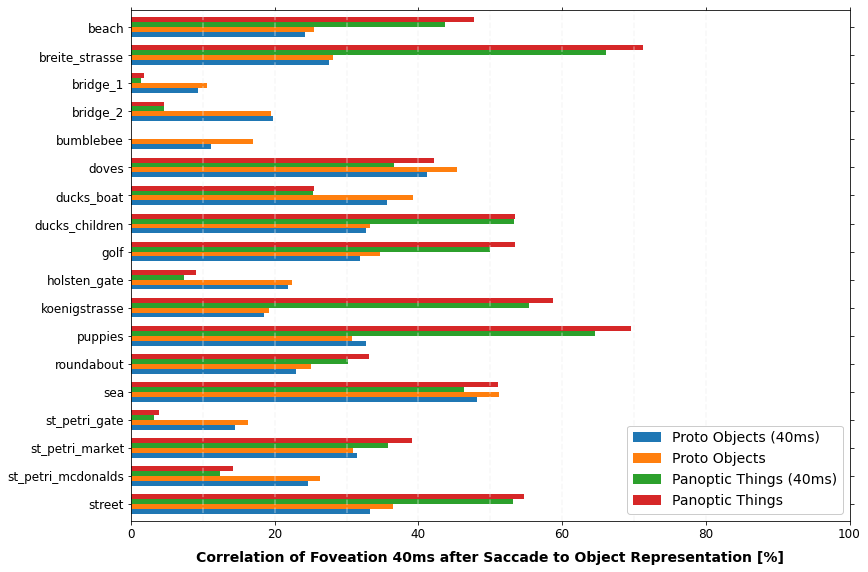

In [216]:
video_names = df_post_saccade.video.unique()
df_bar = pd.DataFrame({'Proto Objects (40ms)': df_post_saccade.groupby(['video']).mean().proto_object.values*100,
                        'Proto Objects': df_foveation.groupby(['video']).mean().proto_object.values*100,
                        'Panoptic Things (40ms)': df_post_saccade.groupby(['video']).mean().isThing.values*100,
                        'Panoptic Things': df_foveation.groupby(['video']).mean().isThing.values*100
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=4, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Correlation of Foveation 40ms after Saccade to Object Representation [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.xlim(0,100)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/corr_both_object_rep_40ms.png', dpi=500)

In [48]:
df_post_saccade.isThing.value_counts(normalize=True)

0    0.663268
1    0.336732
Name: isThing, dtype: float64

In [47]:
df_post_saccade.proto_object.value_counts(normalize=True)

0    0.732942
1    0.267058
Name: proto_object, dtype: float64

In [57]:
df_foveation.isThing.value_counts(normalize=True)

0    0.637141
1    0.362859
Name: isThing, dtype: float64

In [58]:
df_foveation.proto_object.value_counts(normalize=True)

0    0.716892
1    0.283108
Name: proto_object, dtype: float64

In [37]:
len(df_post_saccade)/len(df_foveation)

0.12060479377726634

## Saccades within Objects

In [2]:
path = 'gazecom_gt_event_df'
gazecom_gt_event_df = pd.read_pickle(path)

In [3]:
num_vid_saccades = np.zeros(18)
num_vid_saccades_per_sub = np.zeros(18)
v = 0
for video in gazecom_gt_event_df.video.unique():
    dtemp = gazecom_gt_event_df[(gazecom_gt_event_df.event == 2) & (gazecom_gt_event_df.video == video)]
    num_vid_saccades[v] = len(dtemp)
    num_vid_saccades_per_sub[v] = len(dtemp)/len(dtemp.subject.unique())
    v += 1

In [5]:
len(gazecom_gt_event_df[gazecom_gt_event_df.event==2])

39217

In [67]:
path = 'df_events_foveation'
df_events_foveation = pd.read_pickle(path)

In [165]:
track_return = []
for video in tqdm(df_events_foveation.video.unique()):
    single_track_return = []
    for subject in df_events_foveation.subject.unique(): 
        dtemp = df_events_foveation[(df_events_foveation['video']==video)&(df_events_foveation['subject']==subject)]  
        non_unique_tracks = dtemp.panoptic_track.value_counts()[(dtemp.panoptic_track.value_counts().values > 1)].index
        for track_id in non_unique_tracks:
            single_track_return.append(dtemp.event_id[dtemp.panoptic_track == track_id].diff(periods=1).values[1:])
            #track_return.append(single_track_return[1:])
    if (len(single_track_return) != 0):
        track_return.append(np.hstack(single_track_return))
    else: 
        track_return.append(np.nan)


### Saccades with in an object per video in average per subject

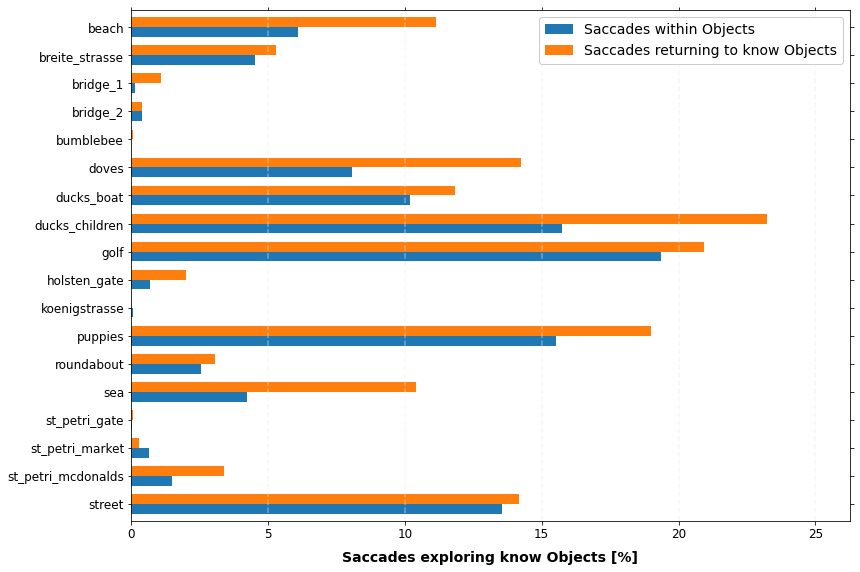

In [205]:
saccades_within_object = [(np.sum(track_return[i] == 2)/num_vid_saccades[i]) for i in range(0,18)]
saccades_return = [(np.sum(track_return[i] != 2)/num_vid_saccades[i]) for i in range(0,18)]

video_names = df_post_saccade.video.unique()
df_bar = pd.DataFrame({'Saccades within Objects': np.array(saccades_within_object)*100,
                        'Saccades returning to know Objects': np.array(saccades_return)*100
                        }
                        ,index = video_names)
df_bar = df_bar.sort_index(ascending=False)
ax = df_bar.plot(kind='barh',rot=0, fontsize=12, figsize=(12,8), width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)

vals = plt.xticks()
for tick in vals[0]:
    plt.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
plt.xlabel("Saccades exploring know Objects [%]",labelpad=10, weight='bold', size=14)
plt.tight_layout()
#plt.xlim(0,100)
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/saccades_within_objects.png', dpi=500)

In [217]:
np.mean(saccades_within_object)

0.05740076757328717

In [218]:
np.mean(saccades_return)

0.07812262227220515